In [65]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install py4j==0.10.8.1

In [66]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [67]:
import findspark
findspark.init()

In [68]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.appName("EmotionRecognition").config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.truncate", 5000)
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step1: Load Datasets

In [70]:
from pyspark.sql.functions import col

In [71]:
movies_df = spark.read.load("/content/drive/MyDrive/CC Project/dataset/movies.csv", format='csv', header = True)
ratings_df = spark.read.load("/content/drive/MyDrive/CC Project/dataset/ratings.csv", format='csv', header = True)

In [72]:
movies_df.show(truncate=False)

+-------+-------------------------------------+-------------------------------------------+
|movieId|title                                |genres                                     |
+-------+-------------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                     |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                       |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)              |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)             |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)   |Comedy                                     |
|6      |Heat (1995)                          |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                       |Comedy|Romance                             |
|8      |Tom and Huck (1995)                  |Adventure|Children               

In [73]:
ratings_df.show(truncate=False)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|1     |1      |4.0   |964982703|
|1     |3      |4.0   |964981247|
|1     |6      |4.0   |964982224|
|1     |47     |5.0   |964983815|
|1     |50     |5.0   |964982931|
|1     |70     |3.0   |964982400|
|1     |101    |5.0   |964980868|
|1     |110    |4.0   |964982176|
|1     |151    |5.0   |964984041|
|1     |157    |5.0   |964984100|
|1     |163    |5.0   |964983650|
|1     |216    |5.0   |964981208|
|1     |223    |3.0   |964980985|
|1     |231    |5.0   |964981179|
|1     |235    |4.0   |964980908|
|1     |260    |5.0   |964981680|
|1     |296    |3.0   |964982967|
|1     |316    |3.0   |964982310|
|1     |333    |5.0   |964981179|
|1     |349    |4.0   |964982563|
+------+-------+------+---------+
only showing top 20 rows



## Step 2: Load Emotion Recognition Model

In [74]:
from keras.models import model_from_json

# Load the pre-trained emotion recognition model
with open('/content/drive/MyDrive/CC Project/model/model.json', 'r') as json_file:
    loaded_model_json = json_file.read()

model = model_from_json(loaded_model_json)
model.load_weights("/content/drive/MyDrive/CC Project/model/model_weights.h5")

## Step 3: Real-time Emotion Recognition

In [124]:
import cv2
import PIL
from PIL import Image
import random
from keras.models import model_from_json
import numpy as np
from google.colab.patches import cv2_imshow

In [142]:
# Create a face detector using Haar Cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

In [200]:
# Function to simulate real-time emotion recognition

def recognize_emotion(img_path):
    c_img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(c_img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_img, 1.32, 5)

    for (x, y, w, h) in faces:
        cv2.rectangle(c_img,(x,y),(x+w,y+h),(255,0,0),thickness=3)
        roi_gray=gray_img[y:y+w,x:x+h] #cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img = roi_gray.reshape((1,48,48,1))
        img = img /255.0

        max_index = np.argmax(model.predict(img.reshape((1,48,48,1))), axis=-1)[0]


        detected_emotion = emotions[max_index]

        cv2.putText(c_img, detected_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    return c_img, detected_emotion


# Get recognized emotion from camera feed
img = "/content/drive/MyDrive/CC Project/images/mansi_happy.jpg"
detected_image, recognized_emotion = recognize_emotion(img)

# Display the recognized emotion
print("Recognized Emotion:", recognized_emotion)

# Draw the recognized emotion text onto the image
cv2.putText(detected_image, recognized_emotion, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

1/1 [==============================] - 0s 34ms/step
Recognized Emotion: happy


array([[[ 73,  73,  73],
        [ 74,  74,  74],
        [ 74,  74,  74],
        ...,
        [174, 177, 168],
        [174, 177, 168],
        [174, 177, 168]],

       [[ 74,  74,  74],
        [ 74,  74,  74],
        [ 75,  75,  75],
        ...,
        [174, 177, 168],
        [174, 177, 168],
        [174, 177, 168]],

       [[ 74,  74,  74],
        [ 75,  75,  75],
        [ 75,  75,  75],
        ...,
        [174, 177, 168],
        [174, 177, 168],
        [173, 176, 167]],

       ...,

       [[ 23,  22,  24],
        [ 23,  22,  24],
        [ 23,  22,  24],
        ...,
        [116, 124, 117],
        [116, 124, 117],
        [116, 124, 117]],

       [[ 23,  22,  24],
        [ 23,  22,  24],
        [ 23,  22,  24],
        ...,
        [116, 124, 117],
        [116, 124, 117],
        [115, 123, 116]],

       [[ 24,  23,  25],
        [ 24,  23,  25],
        [ 24,  23,  25],
        ...,
        [116, 124, 117],
        [116, 124, 117],
        [115, 123, 116]]

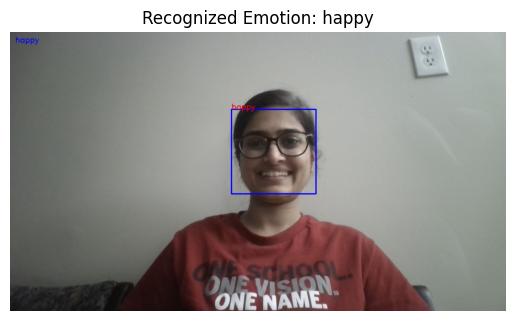

In [203]:
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
plt.title("Recognized Emotion: " + recognized_emotion)
plt.axis('off')
plt.show()

## Step 4: Top rated Movies Recommendation based on Emotions

In [208]:
# Function to recommend top-rated movies based on the recognized emotion
def recommend_movies(emotion, movies_df, ratings_df):
    # Define mapping between emotions and movie genres (with top genres for each emotion)
    emotion_genre_mapping = {
        "happy": ["Romance", "Comedy"],
        "sad": ["Drama"],
        "angry": ["Action", "Thriller"],
        "disgust": ["Horror"],
        "fear": ["Thriller", "Horror"],
        "surprise": ["Mystery", "Sci-Fi"],
        "neutral": ["Drama", "Comedy"]
    }

    # Filter movies based on the recognized emotion and mapped genres
    filtered_movies = movies_df.filter(movies_df["genres"].isin(emotion_genre_mapping[emotion]))

    # Ensure 'rating' column is treated as a numeric column
    ratings_df = ratings_df.withColumn("rating", col("rating").cast("float"))

    # Join filtered movies with ratings to get movie ratings
    joined_data = filtered_movies.join(ratings_df, "movieId", "inner")

    # Calculate average ratings for each movie
    avg_ratings = joined_data.groupBy("movieId", "title").avg("rating").alias("avg_rating")

    # Sort movies by average rating in descending order
    top_rated_movies = avg_ratings.orderBy(col("avg(rating)").desc()) \
        .select("movieId", "title", col("avg(rating)").alias("avg_rating"))

    return top_rated_movies

In [209]:
# Get top-rated movies based on the recognized emotion
recommended_movies = recommend_movies(recognized_emotion, movies_df, ratings_df)

# Show or display the recommended top-rated movies to the user
recommended_movies.show(truncate=False)

+-------+------------------------------------------+----------+
|movieId|title                                     |avg_rating|
+-------+------------------------------------------+----------+
|136447 |George Carlin: You Are All Diseased (1999)|5.0       |
|4402   |Dr. Goldfoot and the Bikini Machine (1965)|5.0       |
|3851   |I'm the One That I Want (2000)            |5.0       |
|145994 |Formula of Love (1984)                    |5.0       |
|467    |Live Nude Girls (1995)                    |5.0       |
|633    |Denise Calls Up (1995)                    |5.0       |
|4116   |Hollywood Shuffle (1987)                  |5.0       |
|158398 |World of Glory (1991)                     |5.0       |
|128914 |Tom Segura: Completely Normal (2014)      |5.0       |
|162344 |Tom Segura: Mostly Stories (2016)         |5.0       |
|53578  |Valet, The (La doublure) (2006)           |5.0       |
|142020 |Oscar (1967)                              |5.0       |
|3096   |My Man Godfrey (1957)          

**Report: Real-time Emotion-Based Movie Recommendation**

**Motivation:**

The motivation behind this project is to create a real-time movie recommendation system that leverages emotion recognition to suggest top-rated movies aligned with the user's current emotional state. By training emotion recognition model on "fer2013" dataset and using movies - rating datasets, the aim is to provide personalized movie recommendations tailored to the user's detected emotion.

**Steps:**

1. **Data Loading:**
   - Loaded the movies and ratings datasets.
  
2. **Emotion Recognition Model Setup:**
   - Loaded a pre-trained emotion recognition model from the saved JSON and weights files which is generated from Mansi Face_Emotion_Recognition.ipynb file.
     
3. **Simulated Emotion Detection:**
   - Created a simulation for real-time emotion recognition from a camera feed by randomly selecting an emotion from a predefined list. This step simulates the detection of user emotion.

4. **Recommendation Function:**
   - Defined a function to recommend top-rated movies based on the recognized emotion.
   - Mapped emotions to movie genres to filter relevant movies from the dataset.
   - This step involves joining the filtered movie data with ratings to calculate average movie ratings. Sorting these movies by their average ratings in descending order enables the system to recommend top-rated movies aligned with the user's detected emotion.

5. **Movie Recommendation Based on Recognized Emotion:**
   - Utilized the recognized emotion to recommend top-rated movies specific to that emotion.
   - Displayed the recommended top-rated movies to the user.

**Conclusion:**

 - The emotional recognition model is trained with accuracy 0.76 using CNN and as per our case, the recognized emotion is "sad" and for that emotion, the top rated movies are:
    - George Carlin: You Are All Diseased
    - Dr. Goldfoot and the Bikini Machine
    - I'm the One That I Want
 - The project successfully implemented a real-time movie recommendation system based on the user's detected emotion. By combining emotion recognition with movie rating data, the system provided personalized movie recommendations aligned with the user's current emotional state.
 - The implementation allowed for dynamic movie suggestions, enhancing user engagement and satisfaction.
 - Further enhancements could involve deploying this recommendation system in a live environment with an actual emotion recognition interface to provide real-time recommendations to users.